In [1]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform


In [2]:
# Load the YOLO model
model = YOLO(r'runs\\segment\\train\\weights\\best.pt')


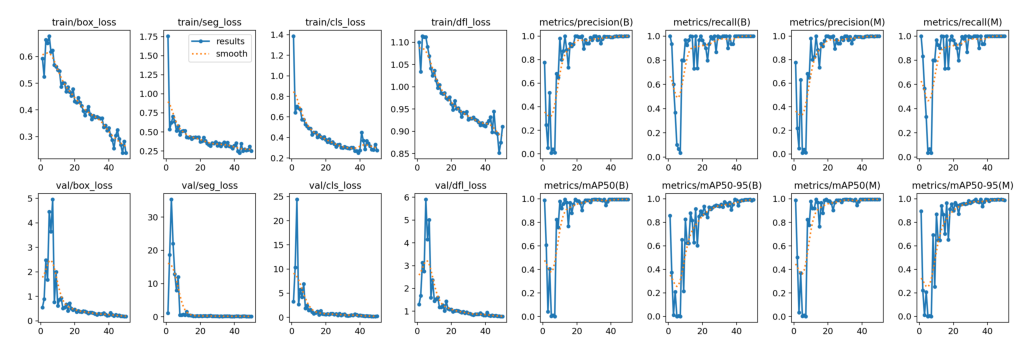

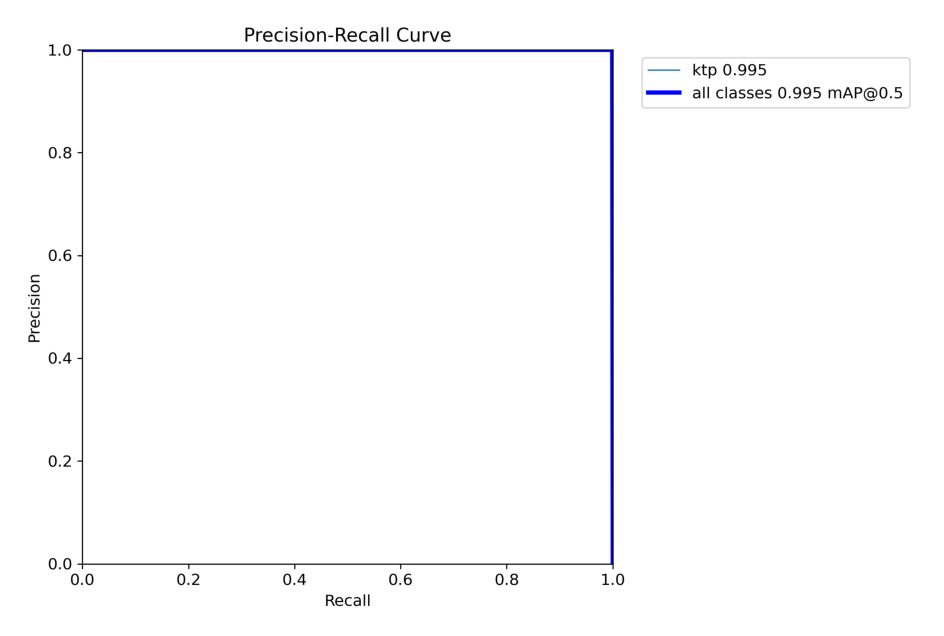

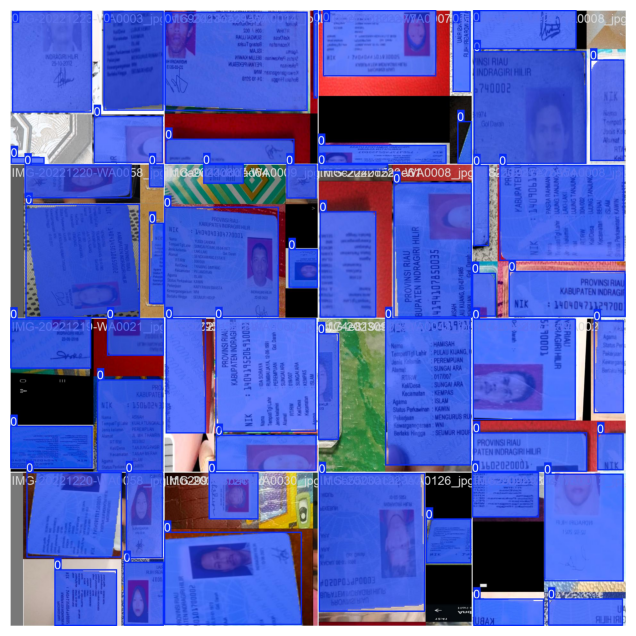

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

evaluation = [
    r"runs\segment\train\results.png",
    r"runs\segment\train\MaskPR_curve.png",
    r"runs\segment\train\train_batch2.jpg"
]

# Loop through and display each image
for eval_image in evaluation:
    img = Image.open(eval_image)
    plt.figure(figsize=(13, 8))  # Adjust figure size (width, height)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()


In [14]:
def resizer(image, width=500):
    """Resize an image while maintaining its aspect ratio."""
    h, w = image.shape[:2]
    height = int((h / w) * width)
    size = (width, height)
    resized_image = cv2.resize(image, size)
    return resized_image, size


In [15]:
def is_rectangle(points):
    """
    Check if four points form a rectangle.
    This is a basic approximation based on distance ratios.
    """
    if points is None or len(points) != 4:
        return False

    # Compute distances between consecutive points
    dists = [np.linalg.norm(points[i] - points[(i + 1) % 4]) for i in range(4)]
    diagonal1 = np.linalg.norm(points[0] - points[2])
    diagonal2 = np.linalg.norm(points[1] - points[3])

    # Check if opposite sides are roughly equal and diagonals are roughly equal
    return (abs(dists[0] - dists[2]) < 10 and
            abs(dists[1] - dists[3]) < 10 and
            abs(diagonal1 - diagonal2) < 10)


In [16]:
def debug_visualize(original, edges, contours, four_points=None):
    """Visualize edges, contours, and detected points for debugging."""
    contour_image = original.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    if four_points is not None:
        for point in four_points:
            cv2.circle(contour_image, tuple(point), 10, (0, 0, 255), -1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edges")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title("Contours with Detected Points")
    plt.axis("off")

    plt.show()


In [18]:
def wrapKTP(mask, original_image):
    """Apply perspective transformation to align the KTP."""
    mask_resized, size = resizer(mask)
    original_resized = resizer(original_image)[0]

    if len(mask_resized.shape) == 2:  # Convert grayscale mask to BGR
        mask_resized = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2BGR)

    # Preprocess the mask for edge detection
    gray = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    # Close gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    four_points = None
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:  # Look for quadrilaterals
            four_points = np.squeeze(approx)
            if is_rectangle(four_points):  # Ensure it's roughly rectangular
                break

    if four_points is None or not is_rectangle(four_points):
        print("No valid quadrilateral found. Using bounding box fallback.")

        # Ensure the mask is binary and single-channel
        mask_binary = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)[1]
        mask_binary = cv2.cvtColor(mask_binary, cv2.COLOR_BGR2GRAY) if len(mask_binary.shape) == 3 else mask_binary

        if mask_binary.dtype != np.uint8:
            mask_binary = mask_binary.astype(np.uint8)

        # Compute the bounding box
        x, y, w, h = cv2.boundingRect(mask_binary)

        # Scale bounding box coordinates to match the original image size
        scale_x = original_image.shape[1] / size[0]
        scale_y = original_image.shape[0] / size[1]
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        cropped_image = original_image[y:y + h, x:x + w]
        return cropped_image, None

    # Scale points back to the original image size
    scale_x = original_image.shape[1] / size[0]
    scale_y = original_image.shape[0] / size[1]
    four_points_scaled = (four_points * [scale_x, scale_y]).astype(int)

    # Apply perspective transformation
    try:
        wrap_image = four_point_transform(original_image, four_points_scaled)
    except Exception as e:
        print(f"Perspective transform error: {e}")
        return original_image, None

    debug_visualize(original_resized, closed_edges, contours, four_points)
    return wrap_image, four_points_scaled


In [ ]:
def plot_results(original, detected, cropped=None, titles=('Original', 'Detected', 'Cropped (Final)')):
    images = [original, detected, cropped]
    num_images = len([img for img in images if img is not None])

    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        if img is not None:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(title)
            plt.axis('off')
    plt.show()



image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\download (1).jpg: 448x640 1 ktp, 677.9ms
Speed: 8.2ms preprocess, 677.9ms inference, 10.1ms postprocess per image at shape (1, 3, 448, 640)


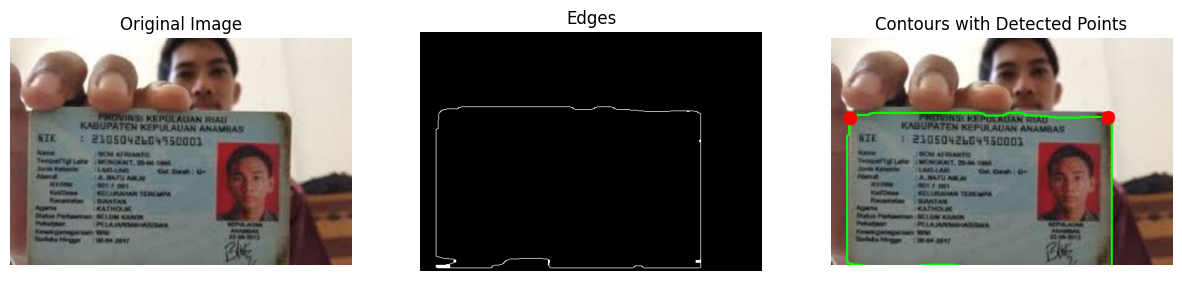

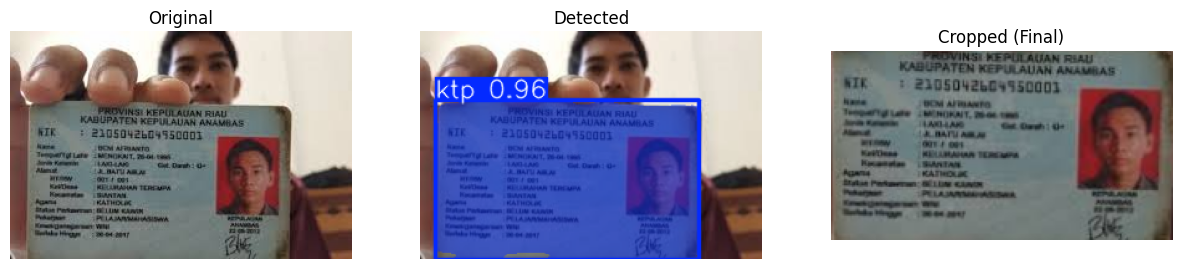


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\download (2).jpg: 384x640 1 ktp, 490.7ms
Speed: 0.0ms preprocess, 490.7ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
No valid quadrilateral found. Using bounding box fallback.


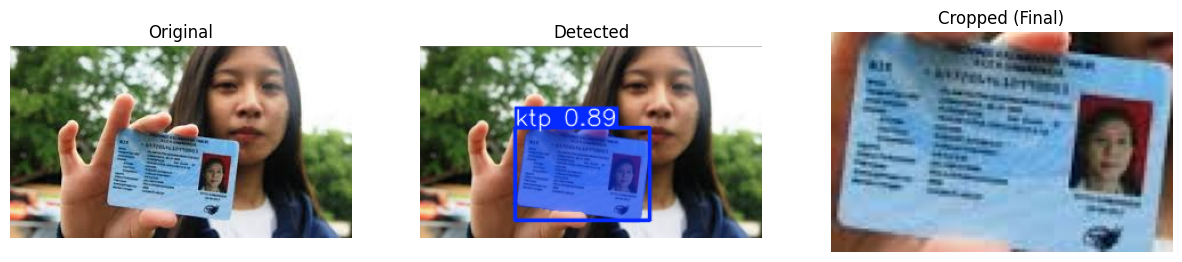


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\download.jpg: 416x640 1 ktp, 569.1ms
Speed: 0.0ms preprocess, 569.1ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)
No valid quadrilateral found. Using bounding box fallback.


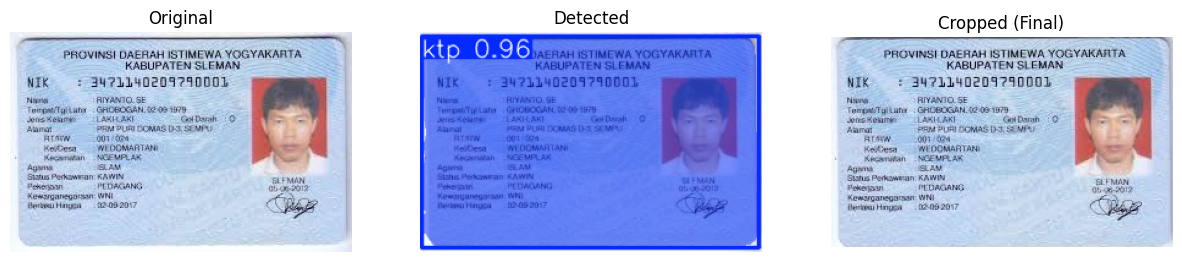


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\images (1).jpg: 352x640 2 ktps, 408.8ms
Speed: 3.1ms preprocess, 408.8ms inference, 8.8ms postprocess per image at shape (1, 3, 352, 640)


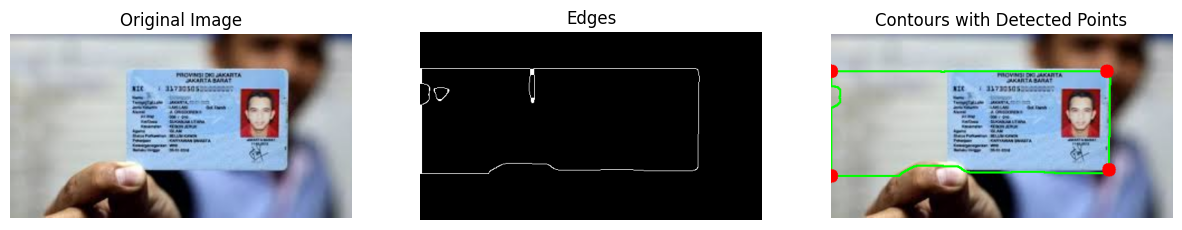

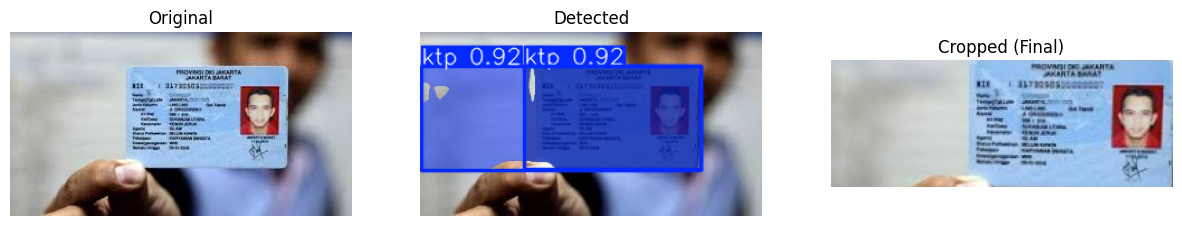


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\images (2).jpg: 384x640 1 ktp, 471.7ms
Speed: 109.9ms preprocess, 471.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
No valid quadrilateral found. Using bounding box fallback.


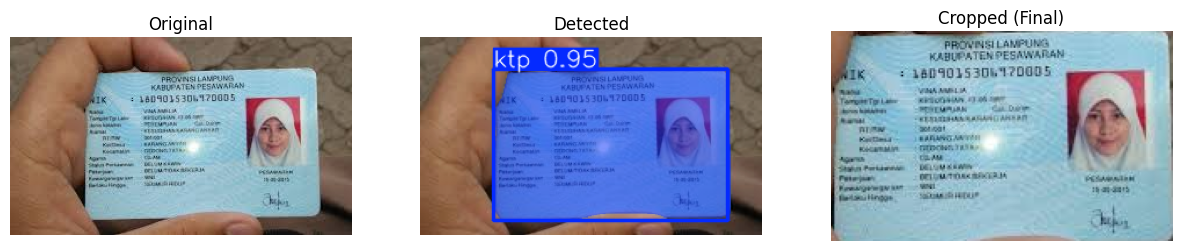


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\images (3).jpg: 448x640 1 ktp, 404.6ms
Speed: 0.0ms preprocess, 404.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
No valid quadrilateral found. Using bounding box fallback.


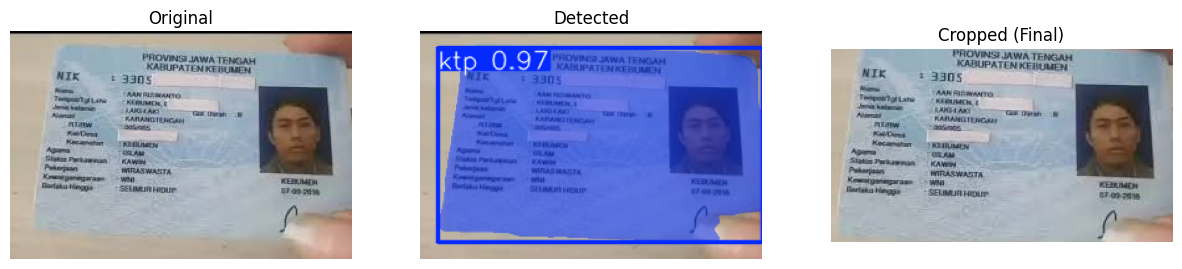


image 1/1 c:\Users\SanjayaCF\Documents\BANGKIT\instanceSegmentation\tesKTP\images.jpg: 480x640 1 ktp, 530.8ms
Speed: 4.0ms preprocess, 530.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
No valid quadrilateral found. Using bounding box fallback.


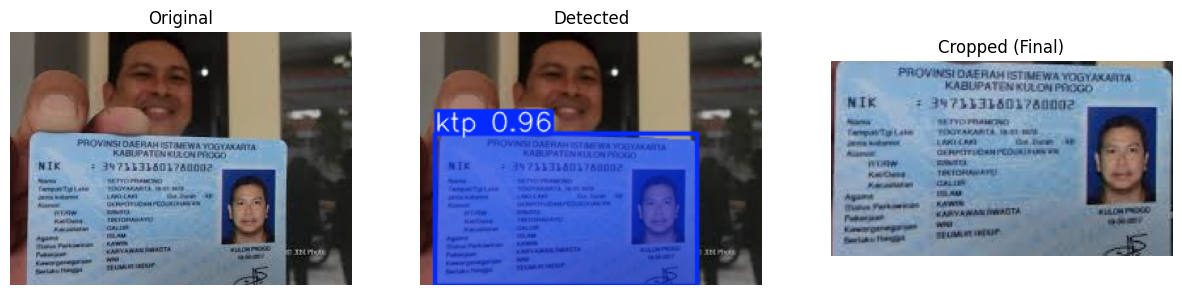

In [21]:
# Folder containing test images
test_folder = 'tesKTP'

# Process each image in the folder
for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)

    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        results = model.predict(source=image_path, save=False, conf=0.5)
        image_colored = cv2.imread(image_path)

        for result in results:
            # Generate detected image
            detected_image = result.plot()

            # Generate mask
            if result.masks is not None and len(result.masks.data) > 0:
                mask = (result.masks.data[0].cpu().numpy() > 0).astype(np.uint8) * 255

                try:
                    cropped_image, four_points_orig = wrapKTP(mask, image_colored)
                    plot_results(image_colored, detected_image, cropped_image)
                except Exception as e:
                    print(f"Error processing {image_name}: {e}")
                    plot_results(image_colored, detected_image, None)
            else:
                print(f"No KTP detected for {image_name}.")
                plot_results(image_colored, detected_image, None)
